# DR Model Evaluation
Evaluate `dr.pth` on the validation set and generate metrics plus plots (confusion matrices, per-class scores, and distribution charts).

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    cohen_kappa_score,
    accuracy_score,
    roc_curve,
    auc,
 )
from sklearn.preprocessing import label_binarize
from src.dataset import DRDataset
from src.model import DRModelV2
from src.transforms import get_valid_transforms
from src.utils import load_state_dict_compatible

# Config
VAL_CSV = "data/val.csv"
IMG_DIR = "data/train_images"
CHECKPOINT = "outputs/checkpoints/dr.pth"
OUT_DIR = "outputs"
BATCH_SIZE = 16
IMG_SIZE = 512

os.makedirs(OUT_DIR, exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

c:\Users\Aadit\miniconda3\envs\dr_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cpu'

In [3]:
# Load model
model = DRModelV2().to(device)
ckpt = torch.load(CHECKPOINT, map_location=device)
_, skipped = load_state_dict_compatible(model, ckpt["model_state"])
if skipped:
    print(f"Skipped {len(skipped)} incompatible keys from checkpoint.")
model.eval()

DRModelV2(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): S

In [4]:
# Data loader and inference
tfm = get_valid_transforms(IMG_SIZE)
val_ds = DRDataset(VAL_CSV, IMG_DIR, transforms=tfm)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

all_preds = []
all_targets = []
all_cum_probs = []

with torch.no_grad():
    for imgs, targets in val_loader:
        imgs = imgs.to(device)
        grades, probs = model.predict_ordinal(imgs)
        all_preds.append(grades.cpu().numpy())
        all_targets.append(targets.numpy())
        all_cum_probs.append(probs.cpu().numpy())

all_preds = np.concatenate(all_preds).astype(int)
all_targets = np.concatenate(all_targets).astype(int)
all_cum_probs = np.concatenate(all_cum_probs)
pred_round = np.clip(all_preds, 0, 4)

len(all_targets), len(pred_round)

(733, 733)

In [5]:
def qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")

def within_one_accuracy(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    return float(np.mean(diff <= 1))

metrics = {
    "QWK": float(qwk(all_targets, pred_round)),
    "MAE": float(mean_absolute_error(all_targets, pred_round)),
    "RMSE": float(np.sqrt(mean_squared_error(all_targets, pred_round))),
    "Within_1_Accuracy": within_one_accuracy(all_targets, pred_round),
    "Accuracy": float(accuracy_score(all_targets, pred_round)),
    "Per-Class Report": classification_report(
        all_targets, pred_round, output_dict=True
    ),
}

metrics_path = os.path.join(OUT_DIR, "eval_metrics_dr.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)

metrics_path

'outputs\\eval_metrics_dr.json'

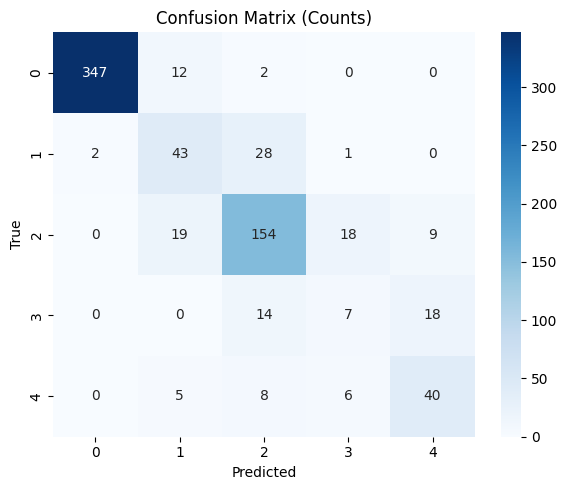

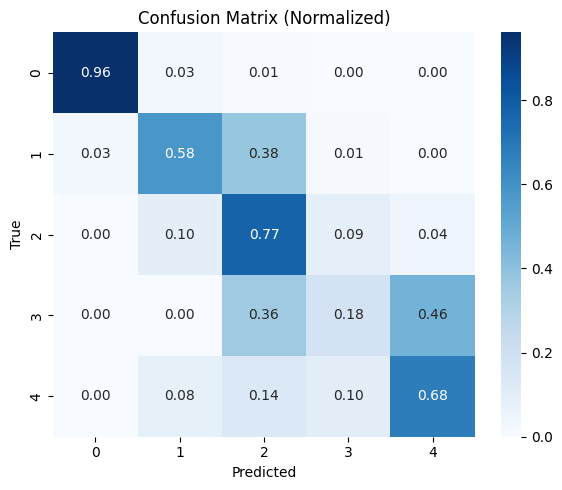

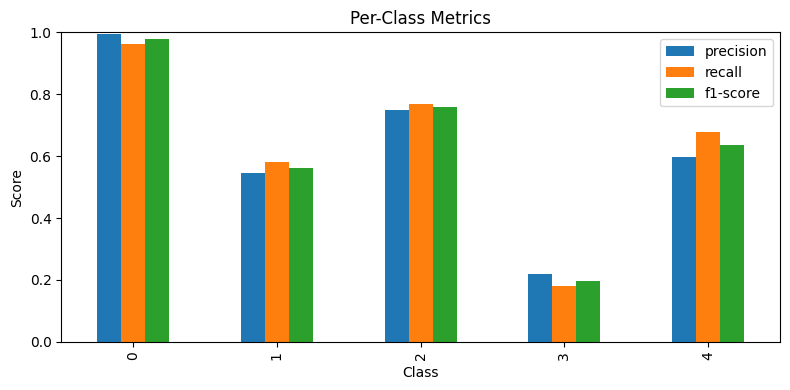

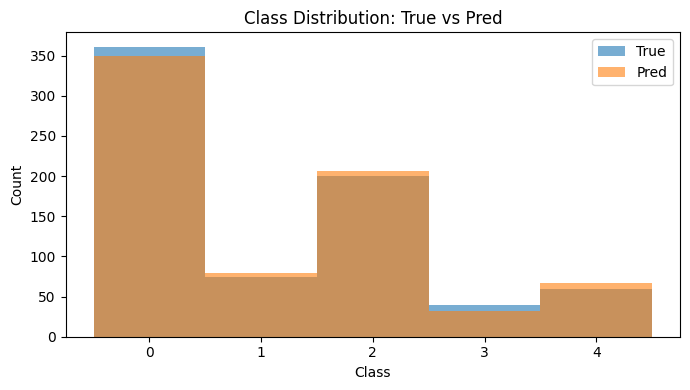

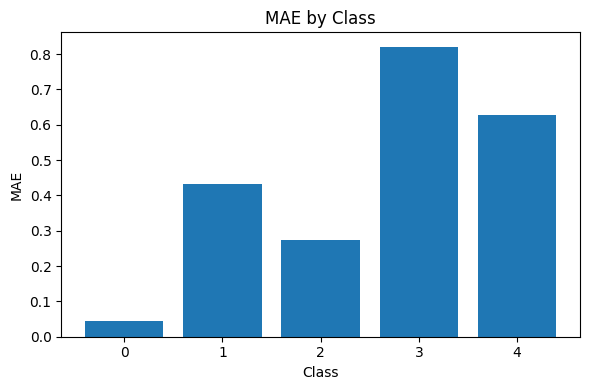

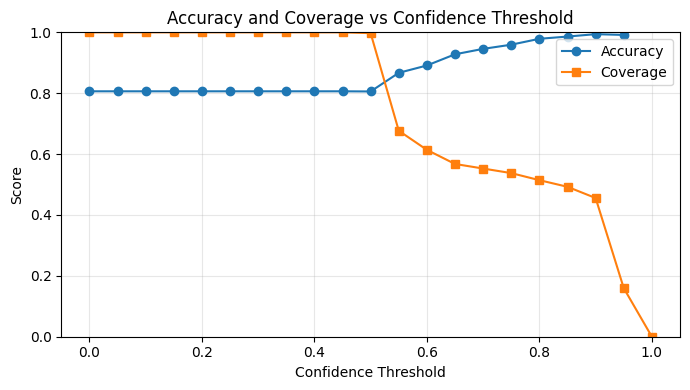

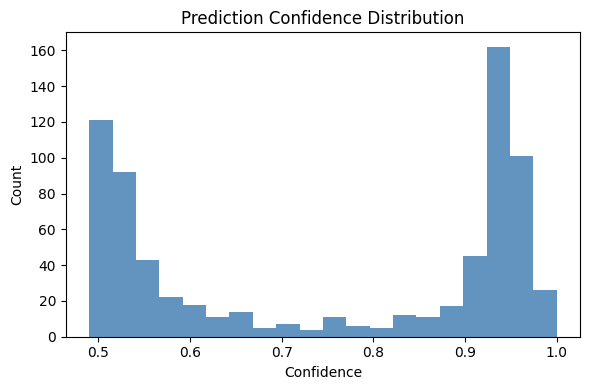

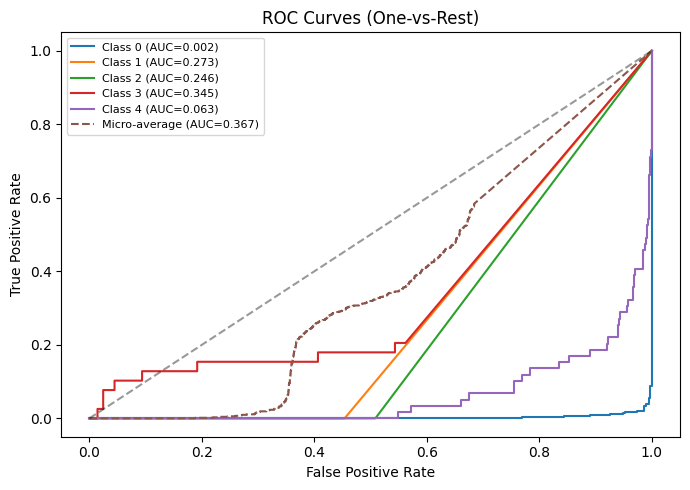

{'metrics_json': 'outputs\\eval_metrics_dr.json',
 'cm_counts': 'outputs\\confusion_matrix_dr_counts.png',
 'cm_norm': 'outputs\\confusion_matrix_dr_norm.png',
 'per_class': 'outputs\\per_class_metrics_dr.png',
 'distribution': 'outputs\\class_distribution_dr.png',
 'mae_by_class': 'outputs\\mae_by_class_dr.png',
 'accuracy_curve': 'outputs\\accuracy_curve_dr.png',
 'confidence_hist': 'outputs\\confidence_hist_dr.png',
 'roc_ovr': 'outputs\\roc_ovr_dr.png'}

In [6]:
# Plots
class_names = ["0", "1", "2", "3", "4"]

# Confusion matrix (counts)
cm = confusion_matrix(all_targets, pred_round)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
cm_path = os.path.join(OUT_DIR, "confusion_matrix_dr_counts.png")
plt.tight_layout()
plt.savefig(cm_path, dpi=150)
plt.show()

# Confusion matrix (normalized)
cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
cmn_path = os.path.join(OUT_DIR, "confusion_matrix_dr_norm.png")
plt.tight_layout()
plt.savefig(cmn_path, dpi=150)
plt.show()

# Per-class precision/recall/F1
report_df = pd.DataFrame(metrics["Per-Class Report"]).T
report_df = report_df.loc[class_names, ["precision", "recall", "f1-score"]]
ax = report_df.plot(kind="bar", figsize=(8, 4))
ax.set_title("Per-Class Metrics")
ax.set_xlabel("Class")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
plt.tight_layout()
prf_path = os.path.join(OUT_DIR, "per_class_metrics_dr.png")
plt.savefig(prf_path, dpi=150)
plt.show()

# True vs predicted distribution
plt.figure(figsize=(7, 4))
plt.hist(all_targets, bins=np.arange(-0.5, 5.5, 1), alpha=0.6, label="True")
plt.hist(pred_round, bins=np.arange(-0.5, 5.5, 1), alpha=0.6, label="Pred")
plt.title("Class Distribution: True vs Pred")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
dist_path = os.path.join(OUT_DIR, "class_distribution_dr.png")
plt.savefig(dist_path, dpi=150)
plt.show()

# MAE by class
mae_by_class = []
for c in range(5):
    idx = all_targets == c
    if np.any(idx):
        mae_by_class.append(mean_absolute_error(all_targets[idx], pred_round[idx]))
    else:
        mae_by_class.append(np.nan)

plt.figure(figsize=(6, 4))
plt.bar(class_names, mae_by_class)
plt.title("MAE by Class")
plt.xlabel("Class")
plt.ylabel("MAE")
plt.tight_layout()
mae_path = os.path.join(OUT_DIR, "mae_by_class_dr.png")
plt.savefig(mae_path, dpi=150)
plt.show()

# Accuracy curve vs confidence threshold
cum = all_cum_probs
p0 = cum[:, 0]
p1 = cum[:, 1] - cum[:, 0]
p2 = cum[:, 2] - cum[:, 1]
p3 = cum[:, 3] - cum[:, 2]
p4 = 1.0 - cum[:, 3]
class_probs = np.stack([p0, p1, p2, p3, p4], axis=1)
class_probs = np.clip(class_probs, 0.0, 1.0)
class_probs = class_probs / class_probs.sum(axis=1, keepdims=True)
confidence = class_probs.max(axis=1)

thresholds = np.linspace(0.0, 1.0, 21)
acc_curve = []
coverage_curve = []
for t in thresholds:
    mask = confidence >= t
    coverage = float(np.mean(mask)) if mask.size else 0.0
    if np.any(mask):
        acc = float(np.mean(pred_round[mask] == all_targets[mask]))
    else:
        acc = np.nan
    acc_curve.append(acc)
    coverage_curve.append(coverage)

plt.figure(figsize=(7, 4))
plt.plot(thresholds, acc_curve, marker="o", label="Accuracy")
plt.plot(thresholds, coverage_curve, marker="s", label="Coverage")
plt.title("Accuracy and Coverage vs Confidence Threshold")
plt.xlabel("Confidence Threshold")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
acc_curve_path = os.path.join(OUT_DIR, "accuracy_curve_dr.png")
plt.savefig(acc_curve_path, dpi=150)
plt.show()

# Confidence histogram
plt.figure(figsize=(6, 4))
plt.hist(confidence, bins=20, color="steelblue", alpha=0.85)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.tight_layout()
conf_hist_path = os.path.join(OUT_DIR, "confidence_hist_dr.png")
plt.savefig(conf_hist_path, dpi=150)
plt.show()

# ROC curves (one-vs-rest)
y_true_bin = label_binarize(all_targets, classes=[0, 1, 2, 3, 4])
plt.figure(figsize=(7, 5))
for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], class_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {name} (AUC={roc_auc:.3f})")

# Micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), class_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle="--", label=f"Micro-average (AUC={roc_auc_micro:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
plt.tight_layout()
roc_path = os.path.join(OUT_DIR, "roc_ovr_dr.png")
plt.savefig(roc_path, dpi=150)
plt.show()

{
    "metrics_json": metrics_path,
    "cm_counts": cm_path,
    "cm_norm": cmn_path,
    "per_class": prf_path,
    "distribution": dist_path,
    "mae_by_class": mae_path,
    "accuracy_curve": acc_curve_path,
    "confidence_hist": conf_hist_path,
    "roc_ovr": roc_path,
}